In [14]:
import sys
sys.path.append('..')
import os
from os.path import join
import numpy as np
import pandas as pd
import connattractor.network as network
from joblib import Parallel, delayed

import seaborn as sns
sns.set_style("whitegrid")

# Emergence of attractor states

In [ ]:
connfile = '../data_in/ex_connectome_partial_correlation.csv'
mtx = pd.read_csv(connfile).iloc[:, 1:]

hopnet = network.Hopfield(mtx.values, scale=True)

In [202]:
def beta_sweep(hopnet, random_num_iter, hopfield_num_iter, beta_iter=np.linspace(0, 0.2, 200),
               n_jobs=-1):
    result = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(beta_sweep_workhorse)(beta, hopnet, random_num_iter, hopfield_num_iter)
        for beta in beta_iter)

    n_attractors, conv_failure, max_it, med_it, std_it, beta = zip(*result)

    df = pd.DataFrame(columns=['beta', 'threshold', 'num_attractors', 'conv_failure', 'max_it', 'med_it', 'sd_it'])

    for i in range(len(max_it)):
        df = pd.concat([df, pd.DataFrame([{'num_attractors': n_attractors[i],
                        'conv_failure': conv_failure[i],
                        'max_it': max_it[i],
                        'med_it': med_it[i],
                        'sd_it': std_it[i],
                        'beta': beta[i],
                        'threshold': hopnet.threshold}])],
                       ignore_index=True)
    return df


def beta_sweep_workhorse(beta, hopnet, random_num_iter=100, hopfield_num_iter=10000):
    # todo: add functionality to allow arrays instead of list of paths as input
    hopnet.beta = beta
    iters = np.zeros(random_num_iter)
    att_states = np.zeros(shape=(random_num_iter, hopnet.num_neuron))


    random_act = np.zeros(shape=(random_num_iter, hopnet.num_neuron))

    sparsity = 10
    base_state = np.concatenate((np.repeat(0.1, sparsity),
                                np.repeat(0, hopnet.num_neuron - sparsity)),
                                axis=0)

    for i in range(random_num_iter):
        random_act[i, :] = network.fun_random_shuffle(base_state)
        att_states[i, :], iters[i] = hopnet.update(random_act[i, :], num_iter=hopfield_num_iter)[:2]

    unique, counts = network.count_unique_states(att_states)
    conv_failure = (iters >= hopfield_num_iter).sum() / random_num_iter * 100

    return len(unique), conv_failure, np.max(iters), np.median(iters), np.std(iters), beta

In [203]:
scale = True

for idx, threshold in enumerate(range(11)):
    hopnet = network.Hopfield(mtx.values,
                              scale=scale,
                              threshold=threshold)
    df = beta_sweep(hopnet=hopnet,
                             random_num_iter=100,
                             hopfield_num_iter=10000,
                             beta_iter=np.linspace(0, 0.08, 41))
    if idx == 0:
        df_pooled = df.copy()
    else :
        df_pooled = pd.concat([df_pooled, df], ignore_index=True)

/tmp/ipykernel_186730/1787298095.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm', max(df_pooled.num_attractors))


Text(0.5, 1.0, 'number of attractor states')

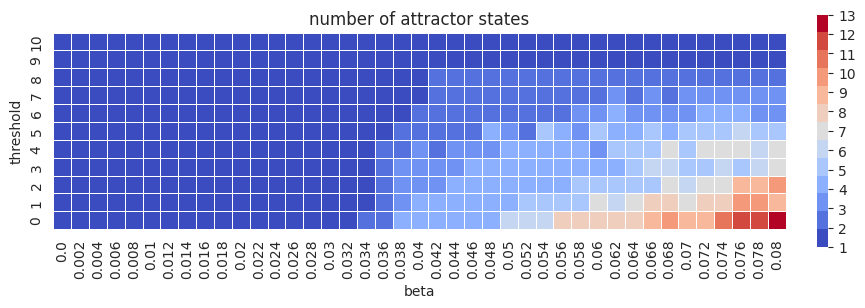

In [290]:
plt.rcParams["figure.figsize"] = (10, 4)

for i in range(11):
    idx = 41*i
    if i == 0:
        arr = df_pooled['num_attractors'].values[idx:idx+41]
    else:
        arr=np.vstack((arr, df_pooled['num_attractors'].values[idx:idx+41]))
        
cmap = cm.get_cmap('coolwarm', max(df_pooled.num_attractors))  
ticks = np.linspace(1, max(df_pooled.num_attractors), max(df_pooled.num_attractors), endpoint=True)

xticks = np.round(np.linspace(0, 0.08, 41), 3)
yticks = range(10,-1,-1)
sns.heatmap(np.flipud(arr.astype(float)), 
            cmap=cmap, 
            xticklabels=xticks, 
            yticklabels=yticks, 
            square=True,
           linewidths=0.5,
           cbar_kws={"ticks":ticks, "fraction":0.015, "pad":0.04})

plt.xlabel('beta')
plt.ylabel('threshold')
plt.title('number of attractor states')

# Attractor state robustness

In [242]:
from connattractor.network import get_n_attractor_states, map_out_attractors
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

def correlate_states(state_set):
    state_ref = state_set[0]
    state_corr = []
    
    for states in state_set[1:]:
        temp = []
        for state in states:
            for ref in state_ref:
                temp.append(np.corrcoef(state, ref)[0, 1])
        state_corr.append(temp)        
    return state_corr


def find_matching_attractor_states(hopfield_net,
                                   reference_state,
                                   corr_thresh=0.7,
                                   beta_start=0):
    
    beta_lin = np.linspace(beta_start, 0.1, 20)
    
    default_result = (None, None, None)
    
    for beta in beta_lin:
        # calc states for beta
        hopfield_net.beta = beta
        n_states, attractors, counts, iters = map_out_attractors(hopfield_net)
        
        # break after too many states
        #if n_states > 20:
        #    print('more than 20 states')
        #    return default_result
        
        state_corr = []
        for state in attractors:
            state_corr.append(np.corrcoef(state, reference_state)[0, 1])     
        
        if np.max(state_corr) >= corr_thresh:
            r = np.max(state_corr)
            #print(f'found matching state with r={r:.3f}')
            return attractors[np.argmax(state_corr)], r, beta
    print('no matching state found')
    return default_result

def robustness_analysis(hopnet, noise_lin, plot_states=False):
    state_corr = []
    nodal_str_ref = np.sum(hopnet.W, axis=1)
    nodal_str_corr = []
    matching_states = []

    np.random.seed(289)
    # get the reference state from the first state pair 
    states, beta = get_n_attractor_states(hopnet, n_target_states=2, verbose=False)[:2]
    ref_state = network.delete_inverse_states(states)[0]

    scaled_weights = hopnet.W
    nodal_str_ref = np.sum(scaled_weights, axis=1)
    hopnet.beta = beta
    
    for noise_std in tqdm(noise_lin):

        M_noise = np.tril(scaled_weights, -1)
        noise = np.tril(np.random.normal(0, noise_std, np.shape(M_noise)), -1)
        M_noise = M_noise + noise
        M_noise = M_noise + np.swapaxes(M_noise,0,1)

        hopnet_noise = network.Hopfield(M_noise, scale=False)
        hopnet_noise.beta = beta

        matching_state, r, beta = find_matching_attractor_states(hopnet_noise, ref_state, beta_start=hopnet.beta)
        
        if plot_states and  matching_state is not None:
            print(f'added noise with {noise_std:.2f} std')
            network.State(matching_state).plot()
            plt.show()

        matching_states.append(matching_state)
        nodal_str_corr.append(np.corrcoef(nodal_str_ref, np.sum(M_noise, axis=1))[0, 1])
        state_corr.append(r)

    return matching_states, state_corr, nodal_str_corr

In [245]:
noise_lin = np.linspace(0, 1, 51)
hopnet = network.Hopfield(mtx.values, scale=True)
matching_states, state_corr, nodal_str_corr = robustness_analysis(hopnet, noise_lin, plot_states=False)

  0%|          | 0/51 [00:00<?, ?it/s]

no matching state found


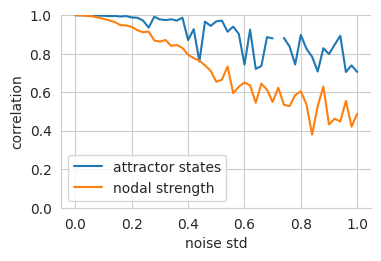

In [246]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [4, 2.5]

ax = plt.subplot(111)

ax.plot(noise_lin, state_corr)
ax.plot(noise_lin, nodal_str_corr)
ax.legend(['attractor states', 'nodal strength'])
plt.xlabel('noise std')
plt.ylabel('correlation')
plt.ylim([0,1])
ax.spines[['right', 'top']].set_visible(False)

plt.show()

# Robustness of connectome

# Fractional occupancy across state configurations (simulation)

In [271]:
simresults = {}
hopfield_embeddings = {}

for beta, noise in [(0.035,0.2), (0.04,0.37), (0.05, 0.65)]:
    simresults[beta] = analysis.simulate_activations(mtx.values, 
                                           noise_coef=noise, 
                                           num_iter=100000, 
                                           beta=beta, 
                                           random_state=2023)
    hopfield_embeddings[beta] = analysis.create_embeddings(simresults[beta], 
                                                 attractor_sample=1000,
                                                 random_state=2023)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.44it/s]


Power_divergenceResult(statistic=4.356, pvalue=0.03687880184110112)
[46.7 53.3]


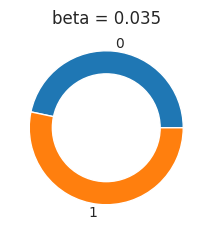

Power_divergenceResult(statistic=341.00800000000004, pvalue=1.3202130113517053e-73)
[10.5 41.9 37.1 10.5]


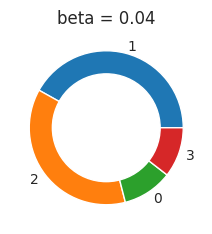

Power_divergenceResult(statistic=488.28800000000007, pvalue=2.692194415786733e-103)
[16.4 30.7 17.8 30.7  2.3  2.1]


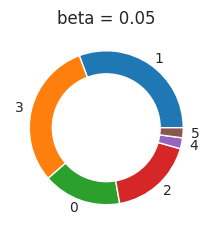

In [287]:
from scipy.stats import chisquare
att_order = {
    0.035: [0, 1],
    0.04: [1,2,0,3],
    0.05: [1,3,0,2,4,5]
}

for beta, embedding in hopfield_embeddings.items():
    sim_attractor_states = embedding.attractor_sample
    label, counts = np.unique(sim_attractor_states, return_counts=True)
    
    plt.pie(counts[att_order[beta]], labels = label[att_order[beta]])

    my_circle=plt.Circle( (0,0), 0.7, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(f'beta = {beta}')
    print(chisquare(counts))
    print(counts / np.sum(counts) * 100)
    plt.show()